In [ ]:
# Simple Keras CNN for household waste classifier with achieved 70-75 percent accuracy

# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import random


In [ ]:
# set seed for consistent results
SEED_NUMBER = 42
random.seed(SEED_NUMBER)
np.random.seed(SEED_NUMBER)
tf.random.set_seed(SEED_NUMBER)
tf.config.experimental.enable_op_determinism()


In [ ]:
# Clean Data if needed
"""
import os
import tensorflow as tf
from pathlib import Path

TRAIN_DIR = Path('/content/content/dataset/train')
VAL_DIR = Path('/content/content/dataset/validation')
directories_to_clean = [TRAIN_DIR, VAL_DIR]

print("--- Starting Plan C (TensorFlow Check) ---")
deleted_files = 0
for dir_path in directories_to_clean:
    print(f"\nScanning: {dir_path}")
    if not dir_path.exists():
        print(f"  [ERROR] Directory does not exist: {dir_path}")
        continue

    for file_path in dir_path.rglob('*'):
        if file_path.is_dir():
            continue

        # Skip common non-image files first
        if file_path.suffix.lower() not in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
            continue

        try:
            # Read the file
            file_data = tf.io.read_file(str(file_path))
            # Try to decode it
            tf.io.decode_image(file_data)
        except Exception as e:
            # This is the one!
            print(f"  [Deleting] TF-level corrupted file: {file_path.name}")
            deleted_files += 1
            os.remove(file_path)

print(f"\n--- Plan C Finished. Deleted {deleted_files} files. ---")
"""

'\nimport os\nimport tensorflow as tf\nfrom pathlib import Path\n\nTRAIN_DIR = Path(\'/content/content/dataset/train\')\nVAL_DIR = Path(\'/content/content/dataset/validation\')\ndirectories_to_clean = [TRAIN_DIR, VAL_DIR]\n\nprint("--- Starting Plan C (TensorFlow Check) ---")\ndeleted_files = 0\nfor dir_path in directories_to_clean:\n    print(f"\nScanning: {dir_path}")\n    if not dir_path.exists():\n        print(f"  [ERROR] Directory does not exist: {dir_path}")\n        continue\n        \n    for file_path in dir_path.rglob(\'*\'):\n        if file_path.is_dir():\n            continue\n        \n        # Skip common non-image files first\n        if file_path.suffix.lower() not in [\'.jpg\', \'.jpeg\', \'.png\', \'.bmp\', \'.gif\']:\n            continue\n            \n        try:\n            # Read the file\n            file_data = tf.io.read_file(str(file_path))\n            # Try to decode it\n            tf.io.decode_image(file_data)\n        except Exception as e:\n       

In [ ]:
# --- Define Parameters ---

IMAGE_SIZE = (180, 180)  # Resize all images to 180x180
BATCH_SIZE = 16         # Process 16 images at a time
TRAIN_DIR = '/content/content/dataset/train'
VAL_DIR = '/content/content/dataset/validation'

train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical' # 'binary' for 2 classes, 'categorical' for 3+
)

validation_dataset = image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

num_classes = len(train_dataset.class_names)

# to end early if loss is minimal
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# This will watch the val_loss. If it stops improving for 2 epochs,
# it will cut the learning rate in half (factor=0.5).
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
# Class weights
##########################################################
from sklearn.utils import class_weight
import numpy as np

# --- Get all the labels from your training data ---
# This is a bit slow, but you only have to do it once.
print("Calculating class weights... This may take a moment.")
train_labels = []
for images, labels in train_dataset:
    # labels is a "one-hot" vector [0, 1, 0, ...]
    # np.argmax converts it back to a single number (e.g., 1)
    train_labels.extend(np.argmax(labels, axis=1))

# --- Calculate the weights ---
# This function automatically calculates the correct "punishment"
# values for each class.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# --- Convert to a dictionary for Keras ---
# Keras needs it in the format {class_index: weight}
# e.g., {0: 1.9, 1: 0.6, 2: 5.1, ...}
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights calculated:")
print(class_weights_dict)
#################################################


# --- Build the CNN Model ---
# This is a simple, standard "stack" of layers
model = keras.Sequential([
    # Normalize pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 3)),

    # --- Start Augmentation ---
    # Randomly flip the image left-to-right
    layers.RandomFlip("horizontal"),
    # Randomly rotate the image a little
    layers.RandomRotation(0.1),
    # Randomly zoom in a little
    layers.RandomZoom(0.1),
    # --- End Augmentation ---

    # First "convolutional" block to find simple edges/colors
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Second block to find more complex shapes
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Third block for more complex shapes
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten the 2D features into a 1D vector
    layers.Flatten(),

    # A "brain" layer to make a final decision
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.40), # Drops 40% of connections

    # The final output
    layers.Dense(num_classes, activation='softmax')
])

custom_optimizer = Adam(learning_rate=0.001)

# --- Compile and Train the Model ---
model.compile(
    optimizer=custom_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# to end early if loss is minimal
early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,  # Let it look through the data 100 times
    callbacks=[early_stopper, reduce_lr], # stop early if loss is minimal
    class_weight=class_weights_dict
)

# --- Save trained model ---
model.save('household_waste_classifier.keras')


Found 15803 files belonging to 10 classes.
Found 3956 files belonging to 10 classes.
Calculating class weights... This may take a moment.
Class Weights calculated:
{0: np.float64(2.093112582781457), 1: np.float64(1.982810539523212), 2: np.float64(1.0823972602739727), 3: np.float64(0.37087538136587656), 4: np.float64(0.6455473856209151), 5: np.float64(1.936642156862745), 6: np.float64(1.178448918717375), 7: np.float64(0.9957781978575929), 8: np.float64(0.9995572422517394), 9: np.float64(2.0875825627476883)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


988/988 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.2220 - loss: 2.1510 - val_accuracy: 0.3885 - val_loss: 1.7180 - learning_rate: 0.0010
Epoch 2/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3899 - loss: 1.7624 - val_accuracy: 0.4282 - val_loss: 1.6678 - learning_rate: 0.0010
Epoch 3/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4442 - loss: 1.6270 - val_accuracy: 0.4330 - val_loss: 1.7133 - learning_rate: 0.0010
Epoch 4/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4919 - loss: 1.5181 - val_accuracy: 0.5359 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 5/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5097 - loss: 1.4473 - val_accuracy: 0.4836 - val_loss: 1.5934 - learning_rate: 0.0010
Epoch 6/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5230 - loss: 1.3996 - val_accuracy: 0.6026 - val_loss: 1.1813 - learning_rate: 0.0010
Epoch 7/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5549 - loss: 

In [ ]:
# Pass the testing dataset
loss, accuracy = model.evaluate(validation_dataset)

# print accuracy
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7135 - loss: 0.9153
Final Model Accuracy: 71.41%


Generating Confusion Matrix...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

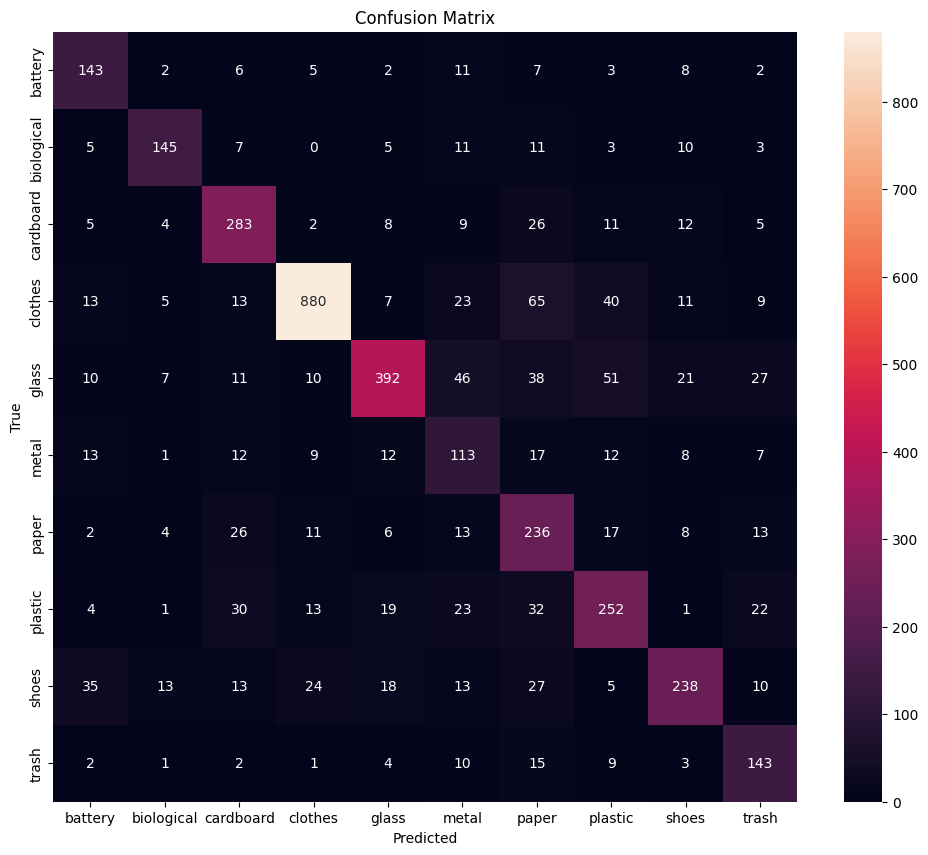

In [ ]:
#Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Get all true labels and predictions from the validation set ---
print("Generating Confusion Matrix...")
all_true_labels = []
all_pred_labels = []

# Loop through the validation data
for images, labels in validation_dataset:
    predictions = model.predict(images)
    # Convert one-hot vectors to class indices
    true_indices = np.argmax(labels, axis=1)
    pred_indices = np.argmax(predictions, axis=1)

    all_true_labels.extend(true_indices)
    all_pred_labels.extend(pred_indices)

# --- Get the class names in the correct order ---
class_names = train_dataset.class_names

# --- Generate the matrix ---
cm = confusion_matrix(all_true_labels, all_pred_labels)

# --- Plot the matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()